# Sweep and Prune Algorithm 

In our previous approach to collision detection, we compared each particle with every other particle, resulting in a computationally expensive $O(N^2)$ operation, where $N$ is the number of particles. To enhance efficiency, we now implement the sweep and prune algorithm.

## Concept of Sweep and Prune

The sweep and prune algorithm is a more efficient method for collision detection. Its efficiency stems from reducing the number of particle pairs we need to check. The key steps of this algorithm are:

**Sweep:** Sort the particles along one axis, typically the $x$-axis. This step orders the particles in a way that adjacent particles in the sorted list are likely to be close in space.

**Prune:** After sorting, we then check for potential collisions only between neighboring particles in this sorted list. This pruning significantly reduces the number of comparisons.

**Repeat for Other Axes:** The process is repeated for the $y$-axis and the $z$-axis. In each iteration, we eliminate pairs of particles that are too far apart to collide based on their coordinates in the respective axis.

**Euclidean Distance Check:** Finally, we validate potential collisions by checking the actual Euclidean distance between particle pairs that remained after the pruning steps. This step ensures accurate detection of collisions.

### Efficiency Gains
This method dramatically reduces the number of comparisons from $O(N^2)$ to approximately $O(N \log N)$, mainly due to sorting. The actual number of particle pairs checked for collision is usually much less than $N$, especially in sparsely populated spaces. This makes the sweep and prune algorithm significantly more efficient for collision detection in systems with a large number of particles.

Note: The exact efficiency depends on the distribution and density of particles. In cases where particles are uniformly distributed, the sweep and prune method shows substantial efficiency improvements. However, in highly clustered scenarios, the performance gain might be less pronounced, but it still outperforms the brute-force $N^2$ approach.

In [41]:
# Code Section: Importing Necessary Libraries and Initializing Variables
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from particula.lagrangian import boundary, integration, collisions, particle_property, particle_pairs

# device = torch.device('cuda')  # or 'cuda:0' to specify a particular GPU
# torch.set_default_device(device)


# Initializing the Torch Generator and setting the data type
torch.manual_seed(1234)  # Set the seed for reproducibility
t_type = torch.float32

## Initialization

We'll use the same initialization as in the previous notebook.

In [42]:
# Setting up the Simulation Parameters and Initial Conditions
# Define fixed parameters
TOTAL_NUMBER_OF_PARTICLES = 500
TIME_STEP = 0.01
SIMULATION_TIME = 10
MASS = 3
CUBE_SIDE = 50
speed = 5
save_points = 50

# Initialize particle positions randomly within the cube
position = torch.rand(
    3,
    TOTAL_NUMBER_OF_PARTICLES,
    dtype=t_type) * CUBE_SIDE - CUBE_SIDE / 2

# Initialize particle velocities randomly
velocity = torch.rand(3, TOTAL_NUMBER_OF_PARTICLES,
                      dtype=t_type) * speed - speed / 2

# Initialize force as zero for all particles
force = torch.zeros(3, TOTAL_NUMBER_OF_PARTICLES, dtype=t_type)

# Set constant mass and density for all particles
mass = torch.ones(TOTAL_NUMBER_OF_PARTICLES, dtype=t_type) * MASS
density = torch.ones(TOTAL_NUMBER_OF_PARTICLES, dtype=t_type) * 1

# Generate indices for particles, could be integer type
indices = torch.arange(TOTAL_NUMBER_OF_PARTICLES, dtype=t_type)  # could be int

# Calculate the total number of iterations for the simulation
total_iterations = int(SIMULATION_TIME / TIME_STEP)

# Initialize a tensor to track the total mass over iterations
total_mass = torch.zeros(total_iterations, dtype=t_type)

# Define gravity acting on all particles
gravity = torch.tensor(
    [0, -9.81, 0]).repeat(TOTAL_NUMBER_OF_PARTICLES, 1).transpose(0, 1)

# Initializing Arrays for Saving Position and Mass Data
# Create arrays to store position and mass data at each save point
save_position = np.zeros((3, TOTAL_NUMBER_OF_PARTICLES, save_points))
save_mass = np.zeros((TOTAL_NUMBER_OF_PARTICLES, save_points))

# Determine which iterations will correspond to the save points
save_iterations = np.linspace(0, total_iterations, save_points, dtype=int)
radius = particle_property.radius_calculation(mass=mass, density=density)

In [43]:
# Initialize counter for saving data
save_counter = 0
start_time = time.time()

for i in range(total_iterations):

    # NEW calculate sweep and prune collision pairs
    radius = particle_property.radius_calculation(mass=mass, density=density)
    valid_collision_indices_pairs = particle_pairs.full_sweep_and_prune(
         position=position, radius=radius)

    if valid_collision_indices_pairs.shape[0] > 0:
        # Coalesce particles that have collided and update their velocity and mass
        velocity, mass = collisions.coalescence(
            position=position,
            velocity=velocity,
            mass=mass,
            radius=radius,
            collision_indices_pairs=valid_collision_indices_pairs)

    # Calculate the force acting on the particles (e.g., gravity)
    force = mass * gravity

    # Integrate the equations of motion to update position and velocity
    position, velocity = integration.leapfrog(
        position=position, velocity=velocity, force=force, mass=mass, time_step=TIME_STEP)

    # Apply boundary conditions for the cube (wrap-around)
    position = boundary.wrapped_cube(position=position, cube_side=CUBE_SIDE)

    # Save the position and mass data at designated save points
    if i == save_iterations[save_counter]:
        save_position[:, :, save_counter] = position.detach().cpu().numpy()
        save_mass[:, save_counter] = mass.detach().cpu().numpy()
        save_counter += 1

# Perform a final save of the position and mass data
save_position[:, :, -1] = position.detach().cpu().numpy()
save_mass[:, -1] = mass.detach().cpu().numpy()

# Calculate the total simulation time
end_time = time.time()
print(f"Total wall time: {end_time - start_time} seconds")
print(f"Ratio of wall time to simulation time: {(end_time - start_time) / SIMULATION_TIME}")

Total wall time: 8.405936002731323 seconds
Ratio of wall time to simulation time: 0.8405936002731323


## Plot Positions

Compared to the previous notebook, the sweep and prune is about 2x faster for this scenario. The exact speedup depends on the number of particles and the distribution of particles in space.

Number of particles at the end: 367


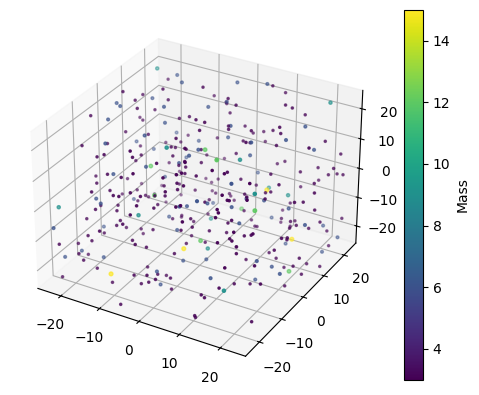

In [44]:
# Processing the Final Data for Visualization

# Select the final time index for the data
time_index = -2
position_final = save_position[:, :, time_index]
mass_final = save_mass[:, time_index]

# Filter out particles with zero mass
filter_zero_mass = mass_final > 0

# Calculate the radius and area of each particle
radius_final = (3 * mass_final / (4 * np.pi *
                density.cpu().numpy())) ** (1 / 3)
particle_area = np.pi * radius_final**2

# Display the number of remaining particles
print(f"Number of particles at the end: {filter_zero_mass.sum()}")

# Creating a 3D Plot for Visualization
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Choose a color map for the scatter plot
cmap = plt.cm.viridis

# Plot the final positions of particles with non-zero mass
scatter_plot = ax.scatter(
    position_final[0, filter_zero_mass],
    position_final[1, filter_zero_mass],
    position_final[2, filter_zero_mass],
    c=mass_final[filter_zero_mass],
    cmap=cmap,
    s=particle_area[filter_zero_mass]  # Particle size based on area
)

# Set axis limits based on cube dimensions
ax.set_xlim(-CUBE_SIDE / 2, CUBE_SIDE / 2)
ax.set_ylim(-CUBE_SIDE / 2, CUBE_SIDE / 2)
ax.set_zlim(-CUBE_SIDE / 2, CUBE_SIDE / 2)

# Add a color bar indicating particle mass
color_bar = plt.colorbar(scatter_plot, ax=ax)
color_bar.set_label('Mass')

# Show the plot with optimized layout
plt.show()
fig.tight_layout()

 ## Analyzing the Mass Distribution of Particles

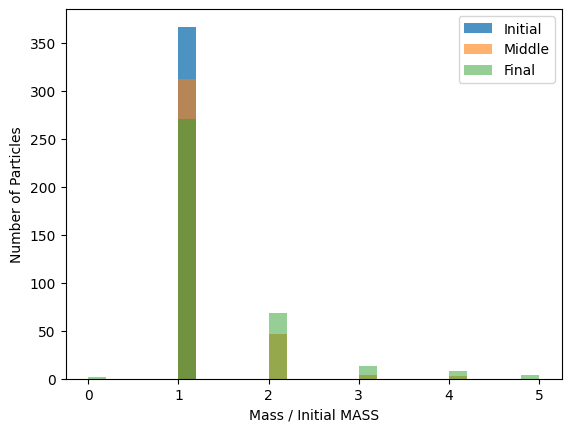

In [45]:
# Visualizing the Mass Distribution at Different Stages

# Create a new figure for the histogram
fig = plt.figure()
ax = fig.add_subplot()
# Normalizing by initial MASS to observe distribution changes
normalized_mass = save_mass[filter_zero_mass, :] / MASS
max_mass = normalized_mass.max()

# Plot histograms of mass distribution at different stages
ax.hist(normalized_mass[:, 0], bins=25,
        alpha=0.8, label='Initial', range=(0, max_mass))
ax.hist(normalized_mass[:, 24], bins=25,
        alpha=0.6, label='Middle', range=(0, max_mass))
ax.hist(normalized_mass[:, -1], bins=25,
        alpha=0.5, label='Final', range=(0, max_mass))

# Setting labels and title for the plot
ax.set_xlabel('Mass / Initial MASS')
ax.set_ylabel('Number of Particles')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()

# Adjust layout for optimal visualization
fig.tight_layout()

## Summary of the Sweep and Prune Algorithm

In our recent work, we've successfully implemented the sweep and prune algorithm for efficient collision detection. This method has demonstrated a notable efficiency improvement over the traditional brute-force approach. As we progress, the next notebook will introduce realistic aerosol initialization and dynamics, further enhancing our simulation's applicability.

### Understanding Sweep and Prune (AABB Algorithm)

The sweep and prune algorithm is often referred to as the Axis-Aligned Bounding Box (AABB) algorithm. This designation stems from the technique's reliance on comparing axis-aligned bounding boxes of particles to detect potential collisions. An axis-aligned bounding box is the smallest box that entirely encapsulates a particle and is aligned with the coordinate axes. By working with these boxes, the algorithm efficiently narrows down collision checks to only those particles whose bounding boxes overlap, significantly reducing the number of necessary calculations.

### Additional Context on AABB

- Efficient Sorting: The key to its efficiency lies in sorting particles along each axis and then checking for overlap, which is computationally less intensive than checking every pair of particles.
- Use in Various Domains: While commonly used in computer graphics and game development for spatial partitioning and collision detection, the AABB approach is also highly relevant in scientific simulations like aerosol dynamics.

## Exploring Other Collision Detection Methods

Beyond sweep and prune, several other advanced collision detection techniques offer improved efficiency over brute-force methods, albeit with increased complexity in implementation. Some noteworthy methods include:

- K-d Tree (Smarter Space Partitioning): This method involves partitioning space into regions using a k-dimensional tree, allowing for efficient searching and nearest-neighbor queries, particularly useful in sparsely populated spaces.
- Bounding Volume Hierarchy (BVH): BVH involves creating a tree structure of bounding volumes, where each node encompasses a subset of objects in the space. Collision detection then proceeds by traversing this tree, significantly speeding up the process in complex scenes.
- GJK Algorithm (Gilbert-Johnson-Keerthi): The GJK algorithm is used for collision detection between convex shapes. It efficiently determines whether two convex shapes intersect and can be extended to calculate the minimum distance between them.

### Additional Considerations

- Choosing the Right Method: The choice of collision detection algorithm depends on the specific requirements of the simulation, such as the number of particles, their distribution, and the required accuracy.
- Hybrid Approaches: In practice, a combination of these methods can be used, depending on the scale and complexity of the simulation environment.
By incorporating these advanced collision detection methods, we can further optimize our simulations for more realistic and computationally efficient aerosol behavior modeling.

In [46]:
## sweep and prune along one axis
help(particle_pairs.single_axis_sweep_and_prune)

Help on function single_axis_sweep_and_prune in module particula.lagrangian.particle_pairs:

single_axis_sweep_and_prune(position_axis: torch.Tensor, radius: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]
    Sweep and prune algorithm for collision detection along a single axis.
    This function identifies pairs of particles that are close enough to
    potentially collide.
    
    Args:
        position_axis (torch.Tensor): The position of particles along a single
            axis.
        radius (torch.Tensor): The radius of particles.
    
    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Two tensors containing the indices
        of potentially colliding particles.

